# **Frequency Domain Motion Blur Model**

In this notebook, we explore how to model motion blur in the Frequency Domain. Motion Blurring is common and modeling has has applications in Image Restoration and nearly all feilds that leverage Computer Vision. With the rise of Neural Networks, modeling motion blur is especially useful for training neural networks to be resilient to the degrdation caused by motion blur. 


In general, the image restoration process involves estimating a degradation function $\mathcal{H}$ and noise value $\eta$ from the original image in order to obtain an estimate of the uncorrupted image. In general there are three ways to estimate the degradation function for image restoration:
- Observation
- Experimentation
- Mathematical Modeling

We will focus on the mathematical modeling of motion blur. 

![](restoration.png)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Obtain Test Image

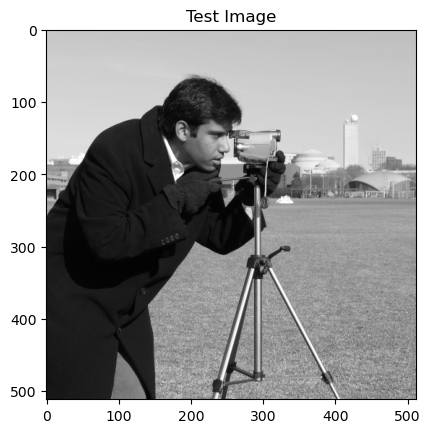

In [2]:
from skimage.data import camera

image = camera()

plt.imshow(image, cmap='gray')
plt.title("Test Image");

## Motion Model

We will start from basic principles and assume that the blurring has been caused by some linear planar motion between the image and the sensor during the acquisition. A sensor (camera) captures an image by integrating the instantaneous exposure over a time interval $T$ (where the shutter is open). Any motion during this time interval is assumed to produce blurring artifacts. We assume a perfect imaging process and instantaeous shutter open/close. We denote the image as $f(x,y)$ which under goes planar motion $(x_0(t), y_0(t))$ to produce the blurred image: $g(x,y)$.

\begin{align*}
    g(x,y) &= \int_0^T f(x - x_0(t), y - y_0(t))dt \quad\qquad \text{Blurred Image in Spatial Domain}
    \\
    G(u,v) &= \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} g(x,y) e^{-i2\pi(ux + vy)}dxdy  \quad\; \text{Blurred Image in Frequency Domain}
    \\
    \\
    \\
    &\text{ Now we will derive the Motion Blurr Model in the Frequency Domain}
    \\
    \\
    G(u,v) &= \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left[ \int_0^T f(x - x_0(t), y - y_0(t))dt \right] e^{-i2\pi(ux + vy)}dxdy
    \\
    &= \int_0^T \left[ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}  f(x - x_0(t), y - y_0(t)) e^{-i2\pi(ux + vy)}dxdy \right] dt
    \\
    &= \int_0^T \left[ F(u,v) e^{-i2\pi(ux_0(t) + vy_0(t))} \right] dt
    \\
    &= F(u,v) \int_0^T e^{-i2\pi(ux_0(t) + vy_0(t))} dt
    \\
    G(u,v) &= F(u,v) H(u,v)
    \\
    \\
    \\
    &\text{ Where The Motion Blur Model is defined as: } H(u,v) = \int_0^T e^{-i2\pi(ux_0(t) + vy_0(t))} dt
\end{align*}

The motion blurr model is represented in the frequency domain, so we can directly multiply it with the Fourier Transform of our original image. Now let's derive the final form for motions: $x_0(t) = \frac{at}{T}$ and $y_0(t) = \frac{bt}{T}$, where $a$ and $b$ are motion constants and $T$ is the time interval for image capture. We will treat these as hyperparameters and select values for them to change the characteristics of the blurring.

\begin{align*}
    H(u,v) &= \int_0^T exp \left( -i2\pi(ux_0(t) + vy_0(t)) \right) dt
    \\
    &= \int_0^T exp \left( -i2\pi(u \frac{at}{T} + v \frac{bt}{T} ) \right) dt
    \\
    &= \int_0^T exp \left( \frac{-i 2\pi t}{T} (u a + v b ) \right) dt
    \\
    &= \frac{-T}{i 2 \pi (u a + v b ) } exp \left( \frac{-i 2\pi t}{T} (u a + v b ) \right) \Big\vert_0^T
    \\
    &= \frac{-T}{i 2 \pi (u a + v b ) } \left[ e ^ {-i 2\pi (u a + v b ) } - e^{0} \right]
    \\
    &= \frac{T}{\pi (u a + v b ) } \frac{1}{2i} \left[ e^{0} - e ^ {-i 2\pi (u a + v b ) } \right]
    \\
    &= \frac{T}{\pi (u a + v b ) } \left( \frac{1}{2i} \left[ e ^ {i \pi (u a + v b ) }  - e ^ {-i \pi (u a + v b ) } \right] \right) e ^ {-i \pi (u a + v b ) } 
    \\
    H(u,v) &= \frac{T}{\pi (u a + v b ) } sin(\pi (u a + v b )) e ^ {-i \pi (u a + v b ) } 
\end{align*}

Note: In genreal we call the motion Blurr Model $H$ the degredation function or degredation transform

In [133]:
def motion_transform(image, a, b, T):
    """
        Obtains Motion Blur Transform
        Inputs:
            image - image to get motion blurr transform
            a - horizontal blur factor
            b - vertical blur factor
            T - exposure time
        Outputs:
            H - Motion Blur Transform in Fourier Domain
    """
    img_rows, img_cols = image.shape

    # get spatial Frequencies in range [-0.5, 0.5]
    u = np.fft.fftfreq(img_cols)[None, :]
    v = np.fft.fftfreq(img_rows)[:, None]
    c = np.pi*(u*a + v*b)  
    H = T/c * np.sin(c) * np.exp(-1j*c)
    H[c == 0] = 1  # account for div by zero

    return H.reshape((img_rows, img_cols))

## Implementation

Here are the steps to implement the Motion Blur Transform

0. Select Hyperparameters for $a$ (horizontal motion), $b$ (vertical motion), $T$ (exposure time)
1. Compute Fast Fourier Transform (FFT) of orignal image ($F$)
2. Compute Motion Degradation/Transformation $H$ in Frequency Domain
3. Multiply the FFT with the Motion Degradation to get the motion blurred image in the Frequency Domain: $G = FH$
4. Compute Inverse FFT (IFFT) on Blurred Image to get data in Spatial Domain: g = ifft2(G)

**0. Select Hyperparameters**

If we select 0 for both $a$ and $b$, then we will obtain an identity transform (no motion blur). If we want to induce blurring in a single direction it helps to always include some small value for the opposing direction *e.g. $a=0.5$ and $b=1e-6$*. Good values for $a$ and $b$ tend to range from $0-0.2$, while the only good value for $T$ seems to be $1$.

In [98]:
# a = 0.05 # (0.03 + 1e-6) # horizontal motion
# b = 1e-6 # -(0.005 + 1e-6) # vertical motion
a = 10
b = 0
T = 1 # exposure time (best value is 1)

**1. Compute FFT of original image**

In [99]:
# F = np.fft.fftshift(np.fft.fft2(image))
F = np.fft.fft2(image)

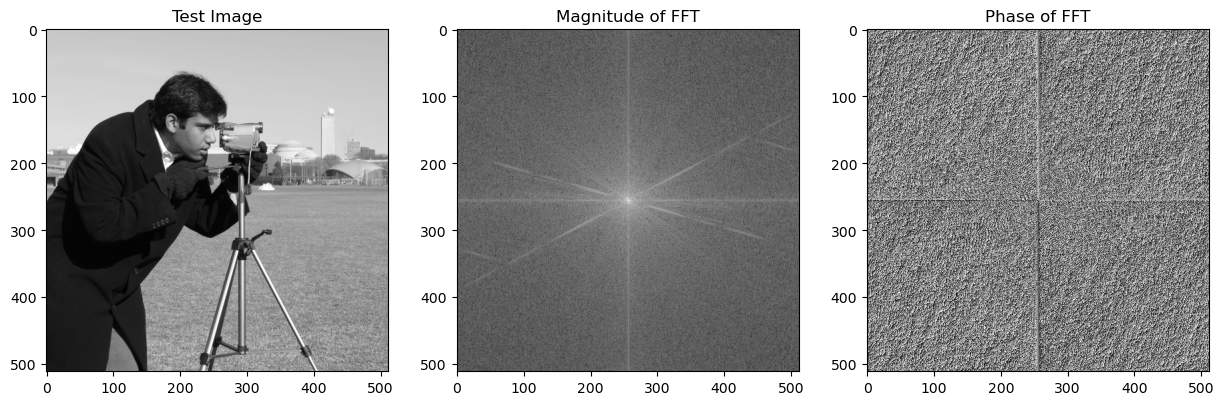

In [100]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test Image")
ax[1].imshow(np.log(np.abs(np.fft.fftshift(F)) + 1e-6), cmap='gray')
ax[1].set_title("Magnitude of FFT")
ax[2].imshow(np.angle(np.fft.fftshift(F)), cmap='gray')
ax[2].set_title("Phase of FFT");

**2. compute motion degredation $H$ in frequency domain**

In [102]:
H = motion_transform(image, a, b, T)

C:\Users\itber\AppData\Local\Temp\ipykernel_36100\4290655368.py:44: RuntimeWarning: divide by zero encountered in divide
  H = T/c * np.sin(c) * np.exp(-1j*c)
C:\Users\itber\AppData\Local\Temp\ipykernel_36100\4290655368.py:44: RuntimeWarning: invalid value encountered in multiply
  H = T/c * np.sin(c) * np.exp(-1j*c)


In [104]:
np.isnan(H).sum()

0

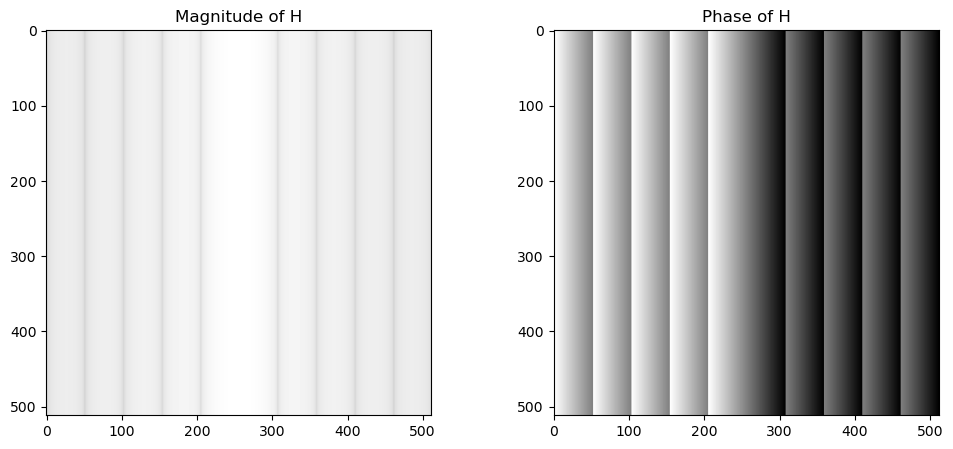

In [105]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(np.log(np.abs(np.fft.fftshift(H))), cmap='gray')
ax[0].set_title("Magnitude of H")
ax[1].imshow(np.angle(np.fft.fftshift(H)), cmap='gray')
ax[1].set_title("Phase of H");

In [106]:
np.log(np.abs(H))[n//2, :].shape

(512,)

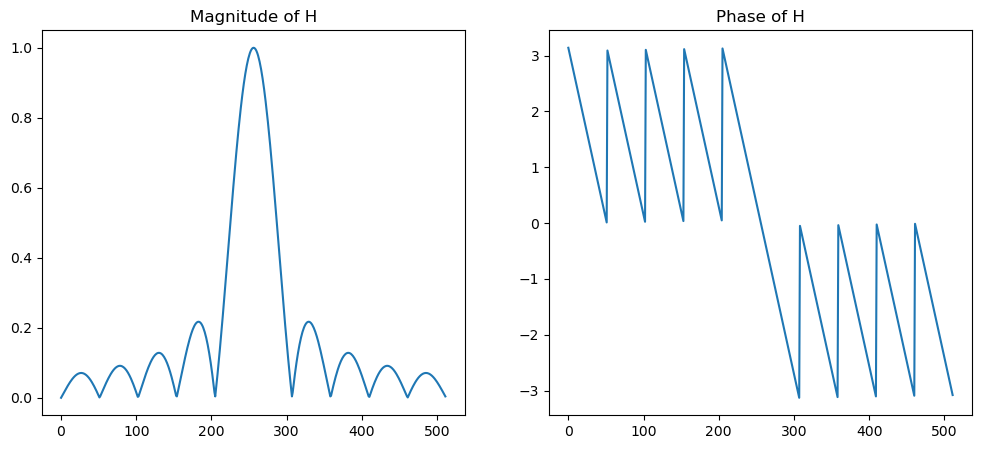

In [107]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.abs(np.fft.fftshift(H))[n//2, :])
ax[0].set_title("Magnitude of H")
ax[1].plot(np.angle(np.fft.fftshift(H))[n//2, :])
ax[1].set_title("Phase of H");

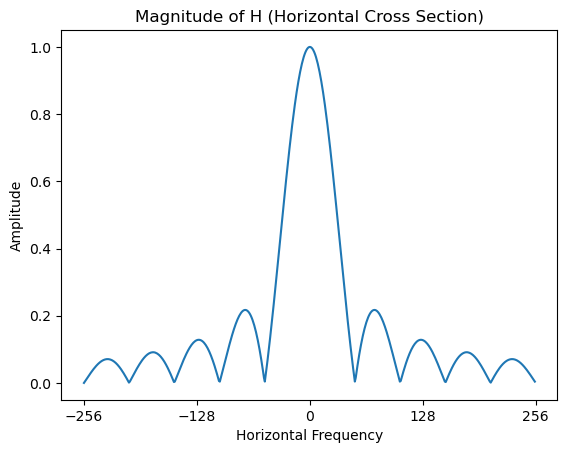

In [108]:
plt.plot(np.arange(-(n//2), (n//2)), np.abs(np.fft.fftshift(H))[n//2, :])
plt.title("Magnitude of H (Horizontal Cross Section)")
plt.xlabel("Horizontal Frequency")
plt.ylabel("Amplitude")
plt.xticks([-256, -128, 0, 128, 256]);

**3. Apply Motion Degrade to Image in Frequency Domain**

In [109]:
G = F*H

In [110]:
G[np.isnan(G)]

array([], dtype=complex128)

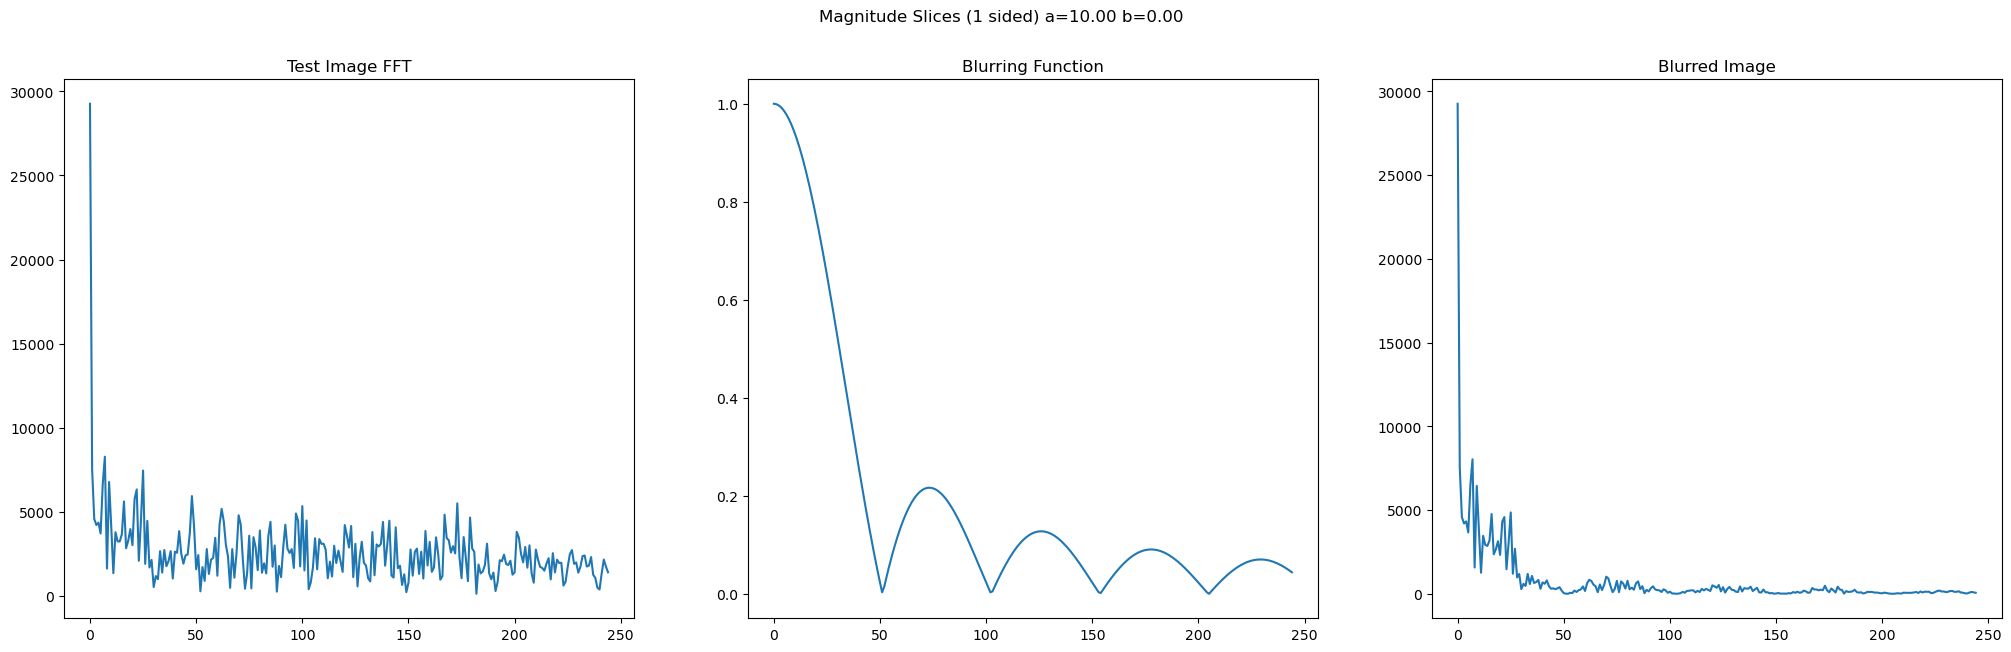

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))
fig.suptitle(f"Magnitude Slices (1 sided) a={a:0.2f} b={b:0.2f}")
ax[0].plot(np.abs(F)[n//2, :245])
ax[0].set_title("Test Image FFT")
ax[1].plot(np.abs(H)[n//2, :245])
ax[1].set_title("Blurring Function")
ax[2].plot(np.abs(G)[n//2, :245])
ax[2].set_title("Blurred Image");

We exlude the peak at the center (DC) since it is so much larger than the rest and makes it difficult to see what' going on. In this slice, we can see that the degredation function notches out several frequency components. As the motion magnitude increases, the number of frequency notches will also increase leading to a more blurred image.

**4. compute ifft to get motion blurred image**

In [112]:
g = np.fft.ifft2(G)

In [113]:
np.isnan(G).sum()

0

In [114]:
np.abs(F).max(), np.abs(G).max()

(33832495.0, 33832495.0)

In [115]:
np.abs(G).max() - np.abs(F).max()

0.0

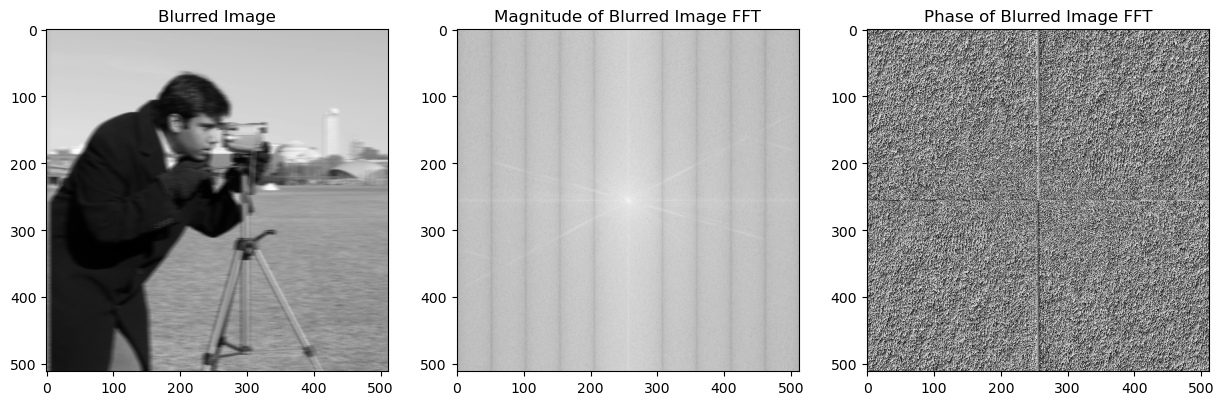

In [116]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.abs(g), cmap='gray')
ax[0].set_title("Blurred Image")
ax[1].imshow(np.log(np.abs(np.fft.fftshift(G))), cmap='gray')
ax[1].set_title("Magnitude of Blurred Image FFT")
ax[2].imshow(np.angle(np.fft.fftshift(G)), cmap='gray')
ax[2].set_title("Phase of Blurred Image FFT");

Notice that the degredation is attenuating periodic components in Frequency Space

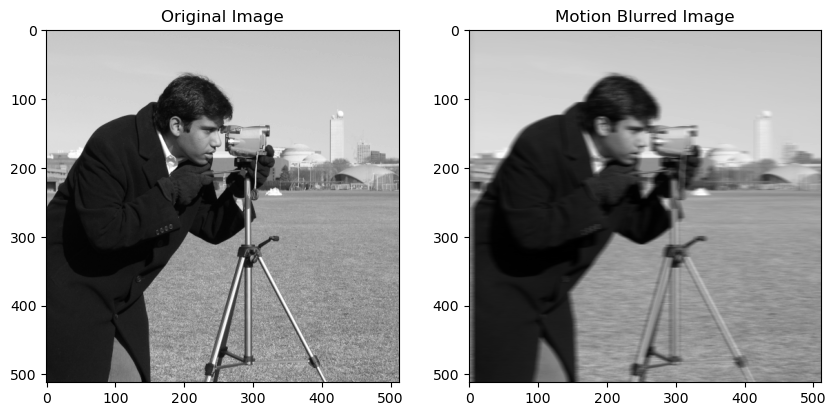

In [117]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(np.abs(g), cmap='gray')
ax[1].set_title("Motion Blurred Image");

## **Pipeline**

Let's place this all in a pipeline

In [129]:
def motion_blur(image, a, b, T=1):
    """ Obtains motion blurred image 
        Inputs:
            image - original image
            a - horizontal motion factor (0-0.2)
            b - vertical motion factor (0-0.2)
        Outputs:
            blurred_image - blurred image
    """
    if (a == 0) and (b == 0):
        return image 
    
    # compute FFT of image
    F = np.fft.fft2(image)

    # compute motion blurr function H in Frequency Domain
    H = motion_transform(image, a, b, T)

    # perform motion blurring in Frequency Domain
    G = F*H

    # get blurred image 
    return np.abs(np.fft.ifft2(G))

In [130]:
%timeit blurred_image = motion_blur(image, a=0.02, b=0.005)

C:\Users\itber\AppData\Local\Temp\ipykernel_36100\4290655368.py:44: RuntimeWarning: divide by zero encountered in divide
  H = T/c * np.sin(c) * np.exp(-1j*c)
C:\Users\itber\AppData\Local\Temp\ipykernel_36100\4290655368.py:44: RuntimeWarning: invalid value encountered in multiply
  H = T/c * np.sin(c) * np.exp(-1j*c)


29 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [147]:
blurred_image = motion_blur(image/255, a=15, b=5, T=1)

C:\Users\itber\AppData\Local\Temp\ipykernel_36100\2000851125.py:18: RuntimeWarning: divide by zero encountered in divide
  H = T/c * np.sin(c) * np.exp(-1j*c)
C:\Users\itber\AppData\Local\Temp\ipykernel_36100\2000851125.py:18: RuntimeWarning: invalid value encountered in multiply
  H = T/c * np.sin(c) * np.exp(-1j*c)


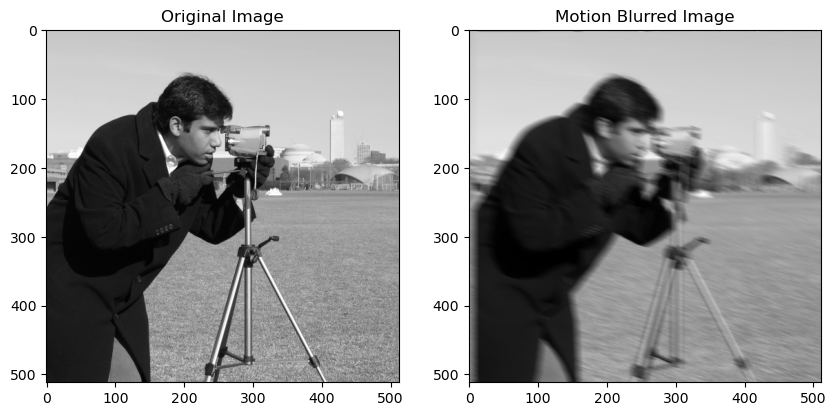

In [148]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(blurred_image, cmap='gray')
ax[1].set_title("Motion Blurred Image");

### PyTorch Implementation

In [149]:
import torch
import torchvision.transforms as transforms

In [207]:
class MotionBlur(object):
    ''' Induces Motion Blurr on a given image (image must be padded to even dimensions)
        Float64 and Complex128 are required dtypes
        Inputs:
            a - horizontal motion factor range: (1e-6 - 0.2)
            b - vertical motion factor range: (1e-6 - 0.2)
        '''

    def __init__(self, a, b):
        self.a = abs(a)
        self.b = abs(b)

    def __call__(self, image):
        if (self.a == 0) and (self.b == 0):
            return image 
        
        btch, c, n, m = image.shape
        
        # get values for a and b
        self.a = torch.distributions.Uniform(-self.a, self.a).sample((btch, 1))
        self.b = torch.distributions.Uniform(-self.b, self.b).sample((btch, 1))
    
        # compute FFT of image
        # image = image.double()
        F = torch.fft.fft2(image)

        # compute motion blurr function H in Frequency Domain
        u = torch.fft.fftfreq(n)[None, :].unsqueeze(0).repeat(btch, 1, 1)
        v = torch.fft.fftfreq(m)[:, None].unsqueeze(0).repeat(btch, 1, 1)
       
        omega = torch.pi*(u*self.a + v*self.b)
        H = (1/omega) * torch.sin(omega) * torch.exp(-(1.0j * omega))
        H[omega == 0] = 1

        H = H.reshape((btch, n, m))

        # perform motion blurring in Frequency Domain for each channel
        G = torch.zeros_like(F)
        for i in range(c):
            G[:, i, :, :] = F[:, i, :, :]*H

        # get blurred image 
        return torch.abs(torch.fft.ifft2(G))

In [219]:
from skimage.data import astronaut

image_tensor = transforms.ToTensor()(astronaut())

In [220]:
image_tensor.unsqueeze(0).shape

torch.Size([1, 3, 512, 512])

In [230]:
blurred_image_tensor = MotionBlur(15, 25)(image_tensor.unsqueeze(0))

In [231]:
print(blurred_image_tensor.min(), blurred_image_tensor.max())

# 0-1 normalize
blurred_image_tensor -= blurred_image_tensor.min()
blurred_image_tensor /= blurred_image_tensor.max()

print(blurred_image_tensor.min(), blurred_image_tensor.max())

tensor(4.8413e-07) tensor(1.0029)
tensor(0.) tensor(1.)


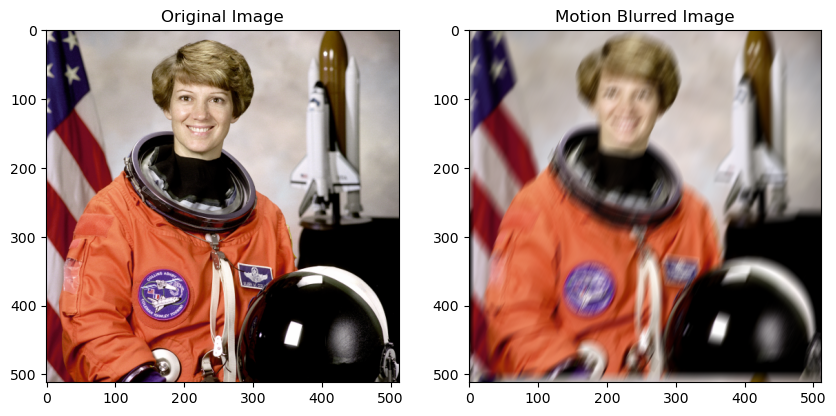

In [232]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(astronaut())
ax[0].set_title("Original Image")
ax[1].imshow(blurred_image_tensor.numpy().squeeze(0).transpose((1,2,0)))
ax[1].set_title("Motion Blurred Image");

Due to the roll over, we would ideally crop and resize afterwards

## References:

- ch 5.6 https://dl.icdst.org/pdfs/files4/01c56e081202b62bd7d3b4f8545775fb.pdf